# Import

In [1]:
import os
import numpy as np

from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import lightkurve as lk
from astroquery.simbad import Simbad
import pandas as pd 
from numpy import genfromtxt

# #tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



## Check GPU

In [2]:
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Data

In [24]:
all_data = np.empty((1,482))
for i in range(25):
  all_data = np.concatenate((all_data,pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v2/'+str(i)+'.csv',delimiter=',').to_numpy()), axis=0)
all_data = all_data[1:].T[1:].T
print(all_data.shape)
print(all_data)
# pd.read_csv('/content/drive/MyDrive/Research - Yihong Song and Rohit Prasanna/Yihong/Data_v2/0.csv',delimiter=',').to_numpy

(36575, 481)
[[757076 '19240929+3635532' 5174 ... 3.676494308688637 1.3925685148610372
  2.128977297424266]
 [757076 '19240929+3635532' 5174 ... 1.3238957656734522
  0.9937602982288734 1.309817227477979]
 [757076 '19240929+3635532' 5174 ... 1.1500678982350347
  1.0179669104715916 1.082825031656266]
 ...
 [2306909 '19291353+3736115' 6062 ... 1.3145102925762593
  1.783229992766084 1.8720227015615565]
 [2306909 '19291353+3736115' 6062 ... 1.886828501682419 2.179288338531378
  1.68985685370382]
 [2306909 '19291353+3736115' 6062 ... 2.6991736792350096
  3.328894181347369 4.246501386271241]]


In [26]:
all_x = all_data.T[10:].T
all_y = all_data.T[2:8].T
print(all_x.shape,all_y.shape)
teff_y = all_y.T[1].T
print(teff_y.shape)

(36575, 471) (36575, 6)
(36575,)


# Machine Learning

In [27]:
train_x,test_x,train_y,test_y=train_test_split(all_x, teff_y, test_size=0.20, random_state=42)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)
train_x = np.asarray(train_x).astype('float32')
test_x = np.asarray(test_x).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

(29260, 471) (7315, 471) (29260,) (7315,)
(29260, 471) (7315, 471) (29260,) (7315,)


In [28]:
tf.test.gpu_device_name() # No GPU Sad :v
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()
model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))

#model.add(layers.Embedding(input_dim=64, output_dim=16))
#model.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,input_dim=(train_x.shape[2])))
model.add(layers.Dense(4096, activation='relu', input_shape=((471,))))
#model.add(layers.Conv1D(1024,1,activation='relu',input_shape=(train_x.shape)))
#model.add(layers.Conv1D(256,1,activation='relu'))
model.add(layers.Dense(2048, activation="relu"))
model.add(layers.Dense(2048, activation="relu"))
model.add(layers.Dense(2048, activation="relu"))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(4, activation="relu"))
# model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              1933312   
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1

2021-11-28 14:38:13.594539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-28 14:38:13.594558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)
monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, 
        patience=30, verbose=1, mode='auto',
        restore_best_weights=True)

In [30]:
history = model.fit(train_x, train_y, epochs=1000,validation_data=(test_x, test_y),callbacks=[monitor], verbose=2)

Epoch 1/1000


2021-11-28 14:38:24.091124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-28 14:38:37.389705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


915/915 - 15s - loss: 11.4096 - accuracy: 0.0000e+00 - val_loss: 0.1606 - val_accuracy: 0.0000e+00
Epoch 2/1000
915/915 - 14s - loss: 0.1752 - accuracy: 0.0000e+00 - val_loss: 0.1683 - val_accuracy: 0.0000e+00
Epoch 3/1000
915/915 - 15s - loss: 0.1588 - accuracy: 0.0000e+00 - val_loss: 0.1926 - val_accuracy: 0.0000e+00
Epoch 4/1000
915/915 - 15s - loss: 0.1521 - accuracy: 0.0000e+00 - val_loss: 0.1556 - val_accuracy: 0.0000e+00
Epoch 5/1000
915/915 - 15s - loss: 0.1735 - accuracy: 0.0000e+00 - val_loss: 0.1676 - val_accuracy: 0.0000e+00
Epoch 6/1000
915/915 - 15s - loss: 0.1753 - accuracy: 0.0000e+00 - val_loss: 0.1431 - val_accuracy: 0.0000e+00
Epoch 7/1000
915/915 - 15s - loss: 0.1586 - accuracy: 0.0000e+00 - val_loss: 0.1538 - val_accuracy: 0.0000e+00
Epoch 8/1000
915/915 - 15s - loss: 0.1707 - accuracy: 0.0000e+00 - val_loss: 0.1921 - val_accuracy: 0.0000e+00
Epoch 9/1000
915/915 - 15s - loss: 0.4740 - accuracy: 0.0000e+00 - val_loss: 0.3930 - val_accuracy: 0.0000e+00
Epoch 10/1000

In [31]:
model.save('/Users/michaelsong/Documents/GitHub/starzam/Models/m2.1')

INFO:tensorflow:Assets written to: /Users/michaelsong/Documents/GitHub/starzam/Models/m2.1/assets


In [32]:

pred_test_y = model.predict(test_x).reshape(-1)
pred_train_y = model.predict(train_x).reshape(-1)
print(pred_test_y.shape,pred_train_y.shape)


2021-11-28 15:08:23.817341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(7315,) (29260,)


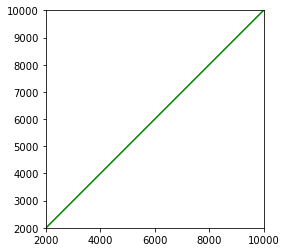

In [39]:
plt.scatter(train_y,pred_train_y, c='red', alpha=0.5,s=1)

plt.scatter(test_y,pred_test_y, c='blue', alpha=0.5,s=1)

linex = np.linspace(2000,10000)
liney = linex
# Create the plot
plt.plot(linex, liney,c="green")

plt.xlim(2000, 10000)
plt.ylim(2000, 10000)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [22]:
def normalize1D(data):
    return np.divide(np.nan_to_num(data,np.nanmean(data)),np.nanmax(data))

In [23]:
mse = np.sqrt(mean_squared_error(normalize1D(test_y),normalize1D(pred_test_y)))
mae = mean_absolute_error(normalize1D(test_y),normalize1D(pred_test_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.20206538 0.1949369
